<p style="font-size:32px"> 
    <b>Personalized cancer diagnosis</b> 
</p>

## Description

<p> Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/ </p>

## Data

<p> :: Memorial Sloan Kettering Cancer Center (MSKCC) :: </p>

There are nine different classes a genetic mutation can be classified on.

Both, training and test, data sets are provided via two different files. One (training/test_variants) provides the information about the genetic mutations, whereas the other (training/test_text) provides the clinical evidence (text) that our human experts used to classify the genetic mutations. Both are linked via the ID field.

Therefore the genetic mutation (row) with ID=15 in the file training_variants, was classified using the clinical evidence (text) from the row with ID=15 in the file training_text

> <b> Some of the test data is machine-generated to prevent hand labeling.</b>


- We have two data files: one conatins the information about the genetic mutations and the other contains the clinical evidence (text) that  human experts/pathologists use to classify the genetic mutations. 
- Both these data files are have a common column called ID
- <p> 
    Data file's information:
    <ul> 
        <li>
        training_variants (ID , Gene, Variations, Class)
        </li>
        <li>
        training_text (ID, Text)
        </li>
    </ul>
</p>

## Real-world/Business objectives and constraints

* No low-latency requirement.
* Interpretability is important.
* Errors can be very costly.
* Probability of a data-point belonging to each class is needed.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from pathlib import Path

Using TensorFlow backend.


<h2> Reading Data</h2>

<h3> Reading Gene and Variation Data</h3>

In [2]:
path = Path('../data/cancer_diagnosis')
list(path.iterdir())

[PosixPath('../data/cancer_diagnosis/msk-redefining-cancer-treatment.zip'),
 PosixPath('../data/cancer_diagnosis/stage1_solution_filtered.csv.7z'),
 PosixPath('../data/cancer_diagnosis/stage2_sample_submission.csv.7z'),
 PosixPath('../data/cancer_diagnosis/stage2_test_text.csv.7z'),
 PosixPath('../data/cancer_diagnosis/stage2_test_variants.csv.7z'),
 PosixPath('../data/cancer_diagnosis/stage_2_private_solution.csv.7z'),
 PosixPath('../data/cancer_diagnosis/test_text'),
 PosixPath('../data/cancer_diagnosis/test_text.zip'),
 PosixPath('../data/cancer_diagnosis/test_variants'),
 PosixPath('../data/cancer_diagnosis/test_variants.zip'),
 PosixPath('../data/cancer_diagnosis/training_text'),
 PosixPath('../data/cancer_diagnosis/training_text.zip'),
 PosixPath('../data/cancer_diagnosis/training_variants'),
 PosixPath('../data/cancer_diagnosis/training_variants.zip')]

<h3> Reading the variants Data</h3>

In [3]:
df_variants = pd.read_csv(path/'training_variants')
print(f"Number of data points and features:: {df_variants.shape}")
df_variants.head()

Number of data points and features:: (3321, 4)


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


<p>
    training_variants is a comma separated file containing the description of the genetic mutations used for training. <br>
    Fields are 
    <ul>
        <li><b>ID : </b>the id of the row used to link the mutation to the clinical evidence</li>
        <li><b>Gene : </b>the gene where this genetic mutation is located </li>
        <li><b>Variation : </b>the aminoacid change for this mutations </li>
        <li><b>Class :</b> 1-9 the class this genetic mutation has been classified on</li>
    </ul>
</p>

<h3> Reading the text Data</h3>

In [4]:
# !head -n 2 {path/'training_text'}

In [5]:
df_text = pd.read_csv(path/'training_text', sep="\|\|", engine="python", names=['ID', 'TEXT'], skiprows=1)
print(f"Number of data points and features:: {df_text.shape}")
df_text.head()


Number of data points and features:: (3321, 2)


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [6]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))

def text_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        total_text = re.sub('\s+', ' ', total_text)
        total_text = total_text.lower()
        
        for word in total_text.split():
            if word not in stop_words:
                string += word + " "
        df_text[column][index] = string

In [7]:
#text processing stage.
start_time = time.clock()
for index, row in df_text.iterrows():
    if type(row['TEXT']) is str:
        text_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print(f'There is no test for row:: {index}')
print(f"Time took for preprocessing the text:: {time.clock() - start_time}")

There is no test for row:: 1109
There is no test for row:: 1277
There is no test for row:: 1407
There is no test for row:: 1639
There is no test for row:: 2755
Time took for preprocessing the text:: 341.312183


In [8]:
df_final = pd.merge(df_variants, df_text, on='ID', how='left')
print(f"Number of data points and features:: {df_final.shape}")
df_final.head()

Number of data points and features:: (3321, 5)


,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [9]:
df_final[df_final.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [10]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 5 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null int64
TEXT         3316 non-null object
dtypes: int64(2), object(3)
memory usage: 155.7+ KB


In [11]:
df_final.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,3321,NaN,NaN,NaN,1660,958.834,0,830,1660,2490,3320
Gene,3321,264,BRCA1,264,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Variation,3321,2996,Truncating Mutations,93,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Class,3321,NaN,NaN,NaN,4.36585,2.30978,1,2,4,7,9
TEXT,3316,1920,pten phosphatase tensin homolog phosphatase un...,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df_final.loc[df_final['TEXT'].isnull(), 'TEXT'] = df_final.Gene + ' ' + df_final.Variation


In [13]:
df_final[df_final.ID == 2755]

,ID,Gene,Variation,Class,TEXT
2755,2755,BRAF,G596C,7,BRAF G596C


In [14]:
df_final.sample(10)

,ID,Gene,Variation,Class,TEXT
2657,2657,BRCA1,S1715N,4,abstract brca1 gene individuals risk breast ov...
1993,1993,MAP2K1,I204T,7,abstract scirrhous subtype gastric cancer high...
3042,3042,KIT,W557_V560del,2,amplifications mutations kit proto oncogene su...
512,512,TP53,C135Y,9,tumor suppressor gene p53 implicated regulatio...
535,535,SMAD2,P305L,1,activation canonical tgf signaling pathway pro...
2693,2693,BRAF,A246P,7,cardio facio cutaneous cfc syndrome characteri...
2731,2731,BRAF,MKRN1-BRAF Fusion,2,pilocytic astrocytomas pa common pediatric bra...
439,439,TP53,N239S,4,abstract loss wild type p53 tumor suppressive ...
187,187,EGFR,L747_P753delinsS,7,abstract malignant pleural effusions mpes ofte...
81,81,CCND3,I290R,2,generalizations emerge studies protein secreti...


<h3> Test, Train and Cross Validation Split</h3>

<h4> Splitting data into train, test and cross validation [64:20:16] </h4>

In [15]:
y_true = df_final['Class'].values
df_final.Gene = df_final.Gene.str.replace('\s+', '_')
df_final.Variation = df_final.Variation.str.replace('\s+', '_')

X_train, test_df, y_train, y_test = train_test_split(df_final, y_true, stratify=y_true, test_size=0.2)
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)


In [16]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


<h4> Distribution of y_i's in Train, Test and Cross Validation datasets</h4>

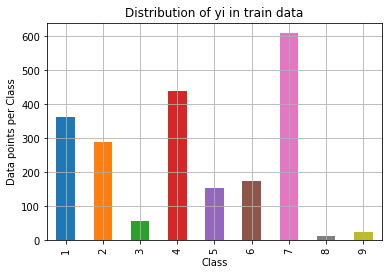

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)


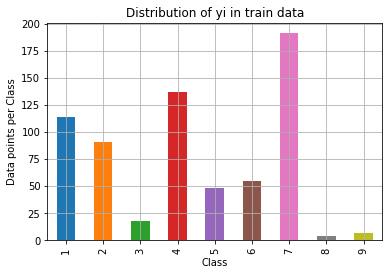

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)


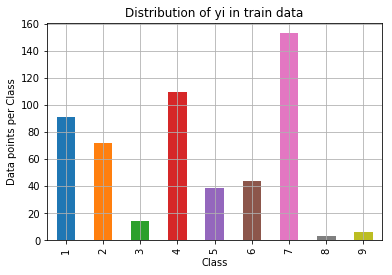

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


In [17]:
train_class_distribution = train_df['Class'].value_counts().sortlevel()
test_class_distribution = test_df['Class'].value_counts().sortlevel()
cv_class_distribution = cv_df['Class'].value_counts().sortlevel()


my_colors = 'rgbkymc'

train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')
print("=" * 100)


test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')
print("=" * 100)

cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-cv_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')
print("=" * 100)

<h3> Prediction using a <span style="color:blue">Random</span> Model</h3>

<p style="font-size:16px"> In a 'Random' Model, we generate the NINE class probabilites randomly such that they sum to 1. </p>

In [18]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A = (C.T / C.sum(axis=1)).T
    
    B = C / C.sum(axis=0)
    
    labels = [1,2,3,4,5,6,7,8,9]
    
    print(":"*20, "Confusion matrix", ":"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print(":"*20, "Precision matrix", ":"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print(":"*20, "Recall matrix", ":"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
                

Log loss on Cross Validation Data using Random Model 2.4182572622765344
Log loss on Test Validation Data using Random Model 2.4597109586943096
:::::::::::::::::::: Confusion matrix ::::::::::::::::::::


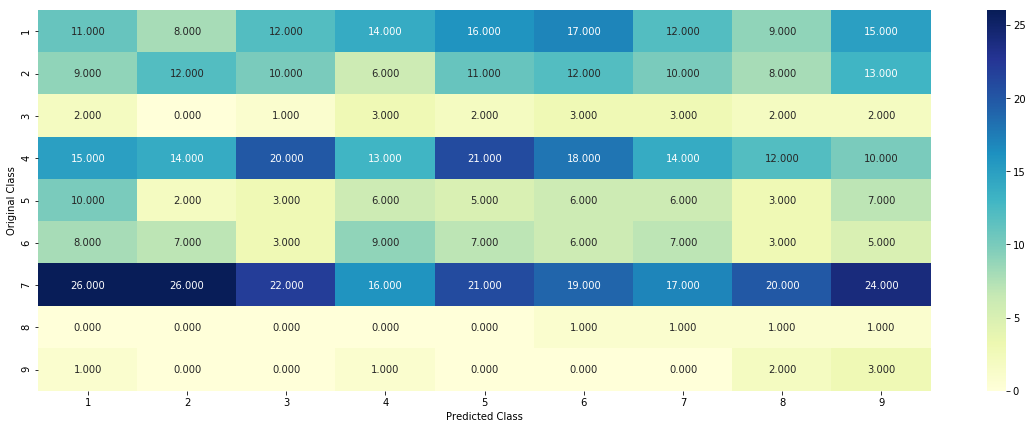

:::::::::::::::::::: Precision matrix ::::::::::::::::::::


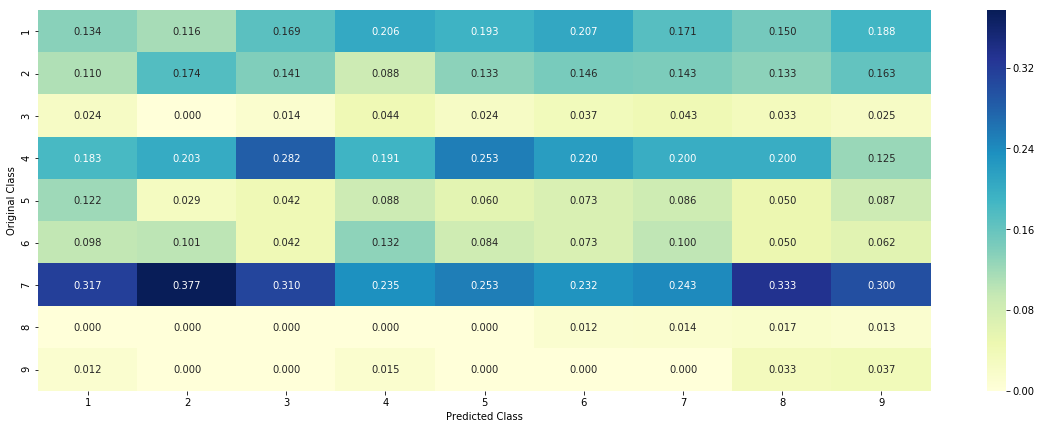

:::::::::::::::::::: Recall matrix ::::::::::::::::::::


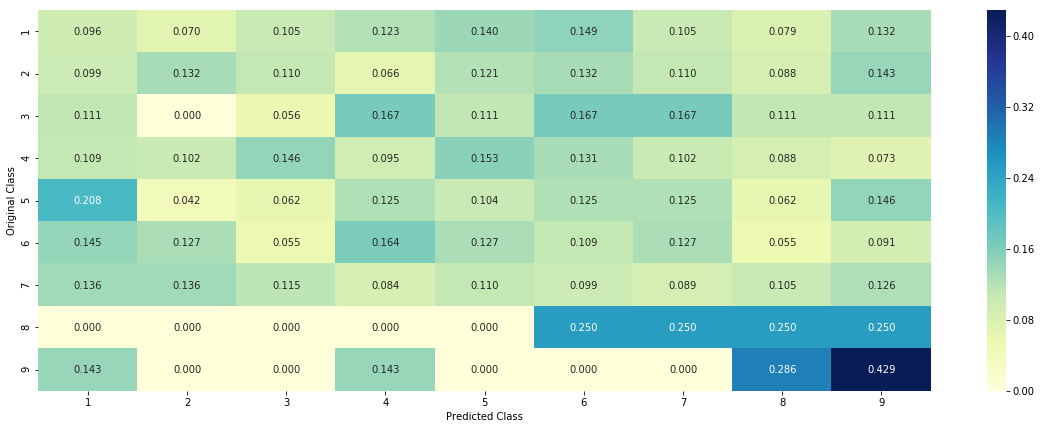

In [19]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039

test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

cv_predicted_y = np.zeros((cv_data_len, 9))

for i in range(cv_data_len):
    rand_probs = np.random.rand(1, 9)
    cv_predicted_y[i] = ((rand_probs / sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv, cv_predicted_y, eps=1e-15))

    
test_predicted_y = np.zeros((test_data_len, 9))

for i in range(test_data_len):
    rand_probs = np.random.rand(1, 9)
    test_predicted_y[i] = ((rand_probs / sum(sum(rand_probs)))[0])
print("Log loss on Test Validation Data using Random Model",log_loss(y_test, test_predicted_y, eps=1e-15))


predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)



### Submission

In [20]:
df_variants_test = pd.read_csv(path/'test_variants', names=df_variants.columns)
print(f"Number of data points and features:: {df_variants_test.shape}")
df_variants_test.head()

Number of data points and features:: (368, 4)


,ID,Gene,Variation,Class
0,0,CBL,H398Q,4
1,1,CBL,S80N,6
2,2,SHOC2,M173I,4
3,3,DICER1,D1709N,4
4,4,PTPRT,S492F,1


In [21]:
df_text_test = pd.read_csv(path/'test_text', sep="\|\|", engine="python", names=['ID', 'TEXT'], skiprows=0)
print(f"Number of data points and features:: {df_text_test.shape}")
df_text_test.head()

Number of data points and features:: (368, 2)


,ID,TEXT
0,0,Oncogenic mutations in the monomeric Casitas B...
1,1,Abstract Background Non-small cell lung canc...
2,2,Rasopathies are phenotypically similar syndrom...
3,3,Abstract DICER1 plays a critical role in mic...
4,4,The receptor protein tyrosine phosphatase T (P...


In [22]:
df_final_test = pd.merge(df_variants_test, df_text_test, on='ID', how='left')
df_final_test.shape

(368, 5)

## Helper Functions

In [23]:
def get_gv_fea_dict(alpha, feature, df):
    value_count = train_df[feature].value_counts()
    gv_dict = dict()
    
    for i, denominator in value_count.items():
        vec = []
        for k in range(1, 10):
            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))
        gv_dict[i]=vec
    return gv_dict

def get_gv_feature(alpha, feature, df):
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    value_count = train_df[feature].value_counts()
    
    gv_fea = []
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    return gv_fea
            

<h2> Univariate Analysis</h2>

<h3>1. Univariate Analysis on Gene Feature</h3>

<p style="font-size:18px;"> <b>Q1.</b> Gene, What type of feature it is ?</p>
<p style="font-size:16px;"><b>Ans.</b> Gene is a categorical variable </p>
<p style="font-size:18px;"> <b>Q2.</b> How many categories are there and How they are distributed?</p>

In [24]:
unique_genes = train_df.Gene.value_counts()
print(f"Number of unique Genes:: {unique_genes.shape[0]}")
unique_genes.head(10)

Number of unique Genes:: 239


BRCA1     172
TP53      103
EGFR       91
BRCA2      79
PTEN       75
KIT        63
BRAF       60
ALK        44
ERBB2      42
PDGFRA     41
Name: Gene, dtype: int64

In [25]:
print("Ans: There are", unique_genes.shape[0] ,"different categories of genes in the train data, and they are distibuted as follows",)

Ans: There are 239 different categories of genes in the train data, and they are distibuted as follows


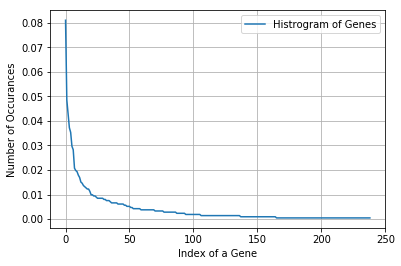

In [26]:
s = np.sum(unique_genes.values)
h = unique_genes.values / s
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()


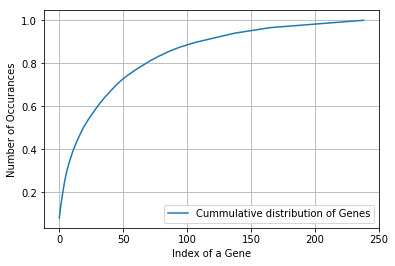

In [27]:
c = np.cumsum(h)
plt.plot(c, label="Cummulative distribution of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

<p style="font-size:18px;"> <b>Q3.</b> How to featurize this Gene feature ?</p>

<p style="font-size:16px;"><b>Ans.</b>there are two ways we can featurize this variable
check out this video: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/
<ol><li>One hot Encoding</li><li>Response coding</li></ol></p>
<p> We will choose the appropriate featurization based on the ML model we use.  For this problem of multi-class classification with categorical features, one-hot encoding is better for Logistic regression while response coding is better for Random Forests. </p>

In [28]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

In [29]:
train_gene_feature_responseCoding.shape

(2124, 9)

In [30]:
# one-hot encoding of Gene feature
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [31]:
train_gene_feature_onehotCoding.shape

(2124, 238)

In [32]:
train_df['Gene'].head()

875     PDGFRA
1120       MET
2295     PRDM1
2486     BRCA1
1114     FANCA
Name: Gene, dtype: object

In [33]:
gene_vectorizer.get_feature_names()

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid2',
 'arid5b',
 'asxl1',
 'asxl2',
 'atm',
 'atr',
 'atrx',
 'aurka',
 'aurkb',
 'axin1',
 'b2m',
 'bap1',
 'bard1',
 'bcl10',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd2',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk6',
 'cdk8',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cdkn2c',
 'cebpa',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'dusp4',
 'egfr',
 'elf3',
 'ep300',
 'epas1',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc3',
 'ercc4',
 'erg',
 'errfi1',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fam58a',
 'fanca',
 'fancc',
 'fat1',
 'fbxw7',
 'fgf19',
 'fgf3',
 'fgf4',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt1',
 'flt3',
 'foxa1',
 'foxl2',
 'foxp1',
 'fubp1',
 'gata3',
 'gli1',
 'gna11',
 'gnaq',
 'gnas',
 'hist1h1c',
 'hla',
 'hnf

<p style="font-size:18px;"> <b>Q4.</b> How good is this gene feature  in predicting y_i?</p>

There are many ways to estimate how good a feature is, in predicting y_i. One of the good methods is to build a proper ML model using just this feature. In this case, we will build a logistic regression model using only Gene feature (one hot encoded) to predict y_i.

For values of alpha =  1e-05 The log loss is: 1.1603155029419672
For values of alpha =  0.0001 The log loss is: 1.1403486814192445
For values of alpha =  0.001 The log loss is: 1.1837238833091195
For values of alpha =  0.01 The log loss is: 1.3040838090068614
For values of alpha =  0.1 The log loss is: 1.416919150849615
For values of alpha =  1 The log loss is: 1.4628857528783408


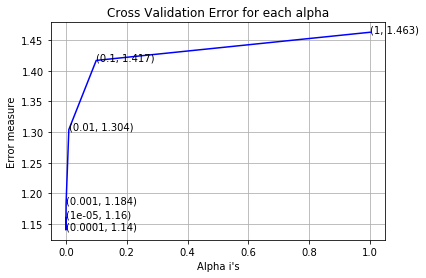

For values of alpha:: 0.0001, the train log loss is:: 1.0242068639637094
For values of alpha:: 0.0001, the cv log loss is:: 1.1403486814192445
For values of alpha:: 0.0001, the test log loss is:: 1.1929635707956177


In [34]:
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error = []

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty="l2", loss="log", random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    calib_clf = CalibratedClassifierCV(clf, method='sigmoid')
    calib_clf.fit(train_gene_feature_onehotCoding, y_train)
    predicted_y = calib_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error.append(log_loss(y_cv, predicted_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predicted_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error, c='b')
for i, txt in enumerate(np.round(cv_log_error, 3)):
    ax.annotate((alpha[i], np.round(txt, 3)), (alpha[i], cv_log_error[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty="l2", loss="log", random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
calib_clf = CalibratedClassifierCV(clf, method='sigmoid')
calib_clf.fit(train_gene_feature_onehotCoding, y_train)

predicted_y = calib_clf.predict_proba(train_gene_feature_onehotCoding)
print(f"For values of alpha:: {alpha[best_alpha]}, the train log loss is:: {log_loss(y_train, predicted_y, labels=clf.classes_, eps=1e-15)}")
predicted_y = calib_clf.predict_proba(cv_gene_feature_onehotCoding)
print(f"For values of alpha:: {alpha[best_alpha]}, the cv log loss is:: {log_loss(y_cv, predicted_y, labels=clf.classes_, eps=1e-15)}")
predicted_y = calib_clf.predict_proba(test_gene_feature_onehotCoding)
print(f"For values of alpha:: {alpha[best_alpha]}, the test log loss is:: {log_loss(y_test, predicted_y, labels=clf.classes_, eps=1e-15)}")




<p style="font-size:18px;"> <b>Q5.</b> Is the Gene feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Yes, it is. Otherwise, the CV and Test errors would be significantly more than train error. </p>

<p style="font-size:18px;"> <b> Q6. </b> How many data points in Test and CV datasets are covered by the genes in train dataset?" </p>

In [35]:
test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Ans
1. In test data 646 out of 665 : 97.14285714285714
2. In cross validation data 519 out of  532 : 97.55639097744361


<h3> Univariate Analysis on Variation Feature</h3>

<p style="font-size:18px;"> <b>Q7.</b> Variation, What type of feature is it ?</p>
<p style="font-size:16px;"><b>Ans.</b> Variation is a categorical variable </p>
<p style="font-size:18px;"> <b>Q8.</b> How many categories are there?</p>

In [36]:
unique_variation = train_df['Variation'].value_counts()
print(f"Number of unique variation:: {unique_variation.shape[0]}")
unique_variation.head(10)

Number of unique variation:: 1923


Truncating_Mutations    56
Amplification           56
Deletion                53
Fusions                 18
G12V                     3
E17K                     3
T58I                     3
Overexpression           3
G12A                     2
ETV6-NTRK3_Fusion        2
Name: Variation, dtype: int64

In [37]:
print("Ans: There are", unique_variation.shape[0] ,"different categories of variation in the train data, and they are distibuted as follows",)


Ans: There are 1923 different categories of variation in the train data, and they are distibuted as follows


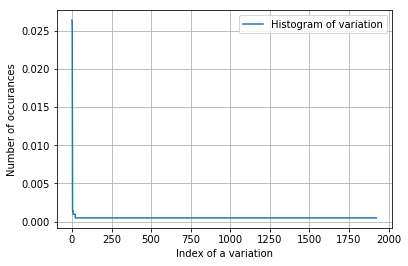

In [38]:
s = np.sum(unique_variation.values)
h = unique_variation.values / s

plt.plot(h, label="Histogram of variation")
plt.xlabel('Index of a variation')
plt.ylabel('Number of occurances')
plt.legend()
plt.grid()
plt.show()

[0.02636535 0.0527307  0.07768362 ... 0.99905838 0.99952919 1.        ]


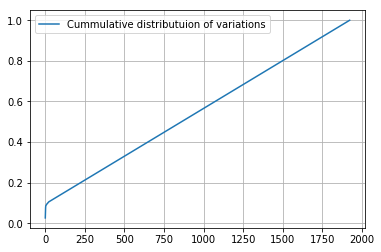

In [39]:
c = np.cumsum(h)
print(c)

plt.plot(c, label="Cummulative distributuion of variations")
plt.legend()
plt.grid()
plt.show()

<p style="font-size:18px;"> <b>Q9.</b> How to featurize this Variation feature ?</p>

<p style="font-size:16px;"><b>Ans.</b>There are two ways we can featurize this variable
check out this video: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/
<ol><li>One hot Encoding</li><li>Response coding</li></ol></p>
<p> We will be using both these methods to featurize the Variation Feature </p>

In [40]:
alpha = 1

train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, 'Variation', train_df))
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, 'Variation', test_df))
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, 'Variation', cv_df))

train_variation_feature_responseCoding.shape, test_variation_feature_responseCoding.shape, cv_variation_feature_responseCoding.shape



((2124, 9), (665, 9), (532, 9))

In [41]:
variation_vectorizer = CountVectorizer()

train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df.Variation)
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df.Variation)
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df.Variation)

train_variation_feature_onehotCoding.shape, test_variation_feature_onehotCoding.shape, cv_variation_feature_onehotCoding.shape


((2124, 1950), (665, 1950), (532, 1950))

In [42]:
variation_vectorizer.get_feature_names()

['126',
 '1_fusion',
 '2010_2471trunc',
 '256_286trunc',
 '385_418del',
 '51',
 '533_534del',
 '534_536del',
 '560_561inser',
 '596_619splice',
 '6a',
 '963_d1010splice',
 '981_1028splice',
 'a1099t',
 'a111p',
 'a11_g12insga',
 'a1200v',
 'a121e',
 'a121v',
 'a1234t',
 'a126d',
 'a126g',
 'a126s',
 'a126v',
 'a134d',
 'a1374v',
 'a1459p',
 'a146t',
 'a146v',
 'a148t',
 'a149p',
 'a1519t',
 'a159t',
 'a161s',
 'a161t',
 'a1669s',
 'a1685s',
 'a1701p',
 'a1708e',
 'a171v',
 'a1823t',
 'a1830t',
 'a1843p',
 'a18d',
 'a197t',
 'a19v',
 'a2034v',
 'a205t',
 'a232v',
 'a23e',
 'a246p',
 'a263v',
 'a2643g',
 'a2717s',
 'a272v',
 'a2770t',
 'a290t',
 'a349p',
 'a36p',
 'a389t',
 'a39p',
 'a40e',
 'a41p',
 'a4419s',
 'a459v',
 'a502_y503dup',
 'a530t',
 'a57v',
 'a598t',
 'a59g',
 'a59t',
 'a60v',
 'a614d',
 'a617t',
 'a633t',
 'a634v',
 'a636p',
 'a677g',
 'a707t',
 'a717g',
 'a727v',
 'a728v',
 'a72v',
 'a750_e758del',
 'a750_e758delinsp',
 'a75p',
 'a763_y764insfqea',
 'a767_v769del',
 'a77

<p style="font-size:18px;"> <b>Q10.</b> How good is this Variation feature  in predicting y_i?</p>

Let's build a model just like the earlier!

For values of alpha =  1e-05 The log loss is: 1.7118219803461105
For values of alpha =  0.0001 The log loss is: 1.7046408893154796
For values of alpha =  0.001 The log loss is: 1.7070005633184369
For values of alpha =  0.01 The log loss is: 1.729696902753529
For values of alpha =  0.1 The log loss is: 1.749695741054967
For values of alpha =  1 The log loss is: 1.747918863461128


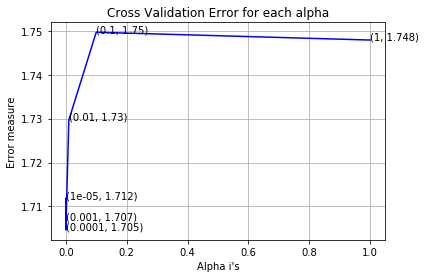

For values of alpha:: 0.0001, the train log loss is:: 0.7650195602506454
For values of alpha:: 0.0001, the cv log loss is:: 1.7046408893154796
For values of alpha:: 0.0001, the test log loss is:: 1.7066525012807707


In [43]:
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error = []

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty="l2", loss="log", random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    calib_clf = CalibratedClassifierCV(clf, method='sigmoid')
    calib_clf.fit(train_variation_feature_onehotCoding, y_train)
    predicted_y = calib_clf.predict_proba(cv_variation_feature_onehotCoding)
    cv_log_error.append(log_loss(y_cv, predicted_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predicted_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error, c='b')
for i, txt in enumerate(np.round(cv_log_error, 3)):
    ax.annotate((alpha[i], np.round(txt, 3)), (alpha[i], cv_log_error[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty="l2", loss="log", random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
calib_clf = CalibratedClassifierCV(clf, method='sigmoid')
calib_clf.fit(train_variation_feature_onehotCoding, y_train)

predicted_y = calib_clf.predict_proba(train_variation_feature_onehotCoding)
print(f"For values of alpha:: {alpha[best_alpha]}, the train log loss is:: {log_loss(y_train, predicted_y, labels=clf.classes_, eps=1e-15)}")
predicted_y = calib_clf.predict_proba(cv_variation_feature_onehotCoding)
print(f"For values of alpha:: {alpha[best_alpha]}, the cv log loss is:: {log_loss(y_cv, predicted_y, labels=clf.classes_, eps=1e-15)}")
predicted_y = calib_clf.predict_proba(test_variation_feature_onehotCoding)
print(f"For values of alpha:: {alpha[best_alpha]}, the test log loss is:: {log_loss(y_test, predicted_y, labels=clf.classes_, eps=1e-15)}")




<p style="font-size:18px;"> <b>Q11.</b> Is the Variation feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Not sure! But lets be very sure using the below analysis. </p>

<p style="font-size:18px;"> <b> Q6. </b> How many data points in Test and CV datasets are covered by the variation in train dataset?" </p>

In [44]:
test_coverage= test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage= cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Ans
1. In test data 62 out of 665 : 9.323308270676693
2. In cross validation data 55 out of  532 : 10.338345864661653


In [45]:
test_coverage = test_df[test_df.Variation.isin(list(set(train_df.Variation)))].shape[0]
cv_coverage = cv_df[cv_df.Variation.isin(list(set(train_df.Variation)))].shape[0]

print('Ans::')
print(f'In test data:: {test_coverage} out of {test_df.shape[0]} :: {(test_coverage/test_df.shape[0])*100}')
print(f'In test data:: {cv_coverage} out of {cv_df.shape[0]} :: {(cv_coverage/cv_df.shape[0])*100}')


Ans::
In test data:: 62 out of 665 :: 9.323308270676693
In test data:: 55 out of 532 :: 10.338345864661653


<h3> Univariate Analysis on Text Feature</h3>

1. How many unique words are present in train data?
2. How are word frequencies distributed?
3. How to featurize text field?
4. Is the text feature useful in predicitng y_i?
5. Is the text feature stable across train, test and CV datasets?

In [46]:
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] += 1
    return dictionary

In [47]:
import math 

def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [48]:
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
train_text_features = text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features), train_text_fea_counts))

print(f"Total number of unique words in train data :: {len(train_text_features)}")


Total number of unique words in train data :: 53497


In [49]:
dict_list = []
for i in range(1, 10):
    cls_text = train_df[train_df.Class == i]
    dict_list.append(extract_dictionary_paddle(cls_text))
    
total_dict = extract_dictionary_paddle(train_df)

confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [50]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [51]:
# https://stackoverflow.com/a/16202486
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [52]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [53]:
#https://stackoverflow.com/a/2258273/4084039
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [54]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({3: 5384, 4: 3643, 6: 3080, 5: 2910, 7: 2395, 8: 1857, 10: 1457, 9: 1437, 12: 1342, 13: 1194, 11: 1138, 15: 973, 14: 929, 16: 735, 18: 645, 20: 607, 17: 559, 24: 519, 22: 512, 21: 485, 19: 479, 27: 409, 25: 382, 28: 365, 42: 356, 26: 355, 23: 332, 30: 327, 29: 306, 36: 277, 32: 275, 53: 268, 40: 259, 33: 256, 38: 243, 35: 234, 31: 229, 34: 227, 39: 215, 41: 214, 44: 194, 37: 189, 46: 182, 48: 175, 51: 174, 45: 168, 54: 160, 43: 160, 60: 156, 50: 156, 49: 153, 47: 151, 52: 139, 55: 135, 62: 134, 57: 128, 56: 124, 59: 122, 58: 118, 66: 116, 64: 114, 72: 113, 61: 109, 65: 108, 63: 105, 82: 101, 73: 97, 68: 97, 90: 95, 80: 90, 70: 90, 71: 88, 84: 87, 74: 87, 67: 87, 81: 84, 88: 78, 78: 78, 79: 77, 69: 77, 77: 71, 92: 70, 76: 70, 110: 69, 99: 68, 98: 66, 87: 66, 85: 66, 106: 65, 91: 65, 75: 65, 96: 64, 97: 63, 86: 61, 123: 60, 109: 60, 83: 60, 89: 58, 104: 57, 94: 57, 117: 56, 93: 53, 103: 52, 107: 50, 102: 50, 100: 48, 105: 46, 95: 45, 124: 44, 114: 44, 142: 43, 132: 43, 120: 43, 1

For values of alpha =  1e-05 The log loss is: 1.3399980498671804
For values of alpha =  0.0001 The log loss is: 1.20022350672972
For values of alpha =  0.001 The log loss is: 1.1847459647235863
For values of alpha =  0.01 The log loss is: 1.276952490082929
For values of alpha =  0.1 The log loss is: 1.4648440483216707
For values of alpha =  1 The log loss is: 1.6474411308151276


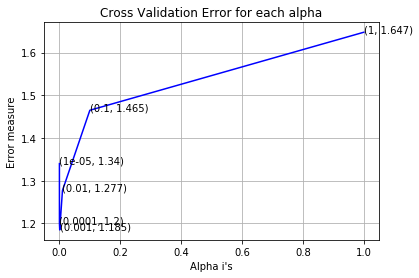

For values of alpha:: 0.001, the train log loss is:: 0.7118818034081168
For values of alpha:: 0.001, the cv log loss is:: 1.1847459647235863
For values of alpha:: 0.001, the test log loss is:: 1.1158282143482459


In [55]:
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error = []

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty="l2", loss="log", random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    calib_clf = CalibratedClassifierCV(clf, method='sigmoid')
    calib_clf.fit(train_text_feature_onehotCoding, y_train)
    predicted_y = calib_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error.append(log_loss(y_cv, predicted_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predicted_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error, c='b')
for i, txt in enumerate(np.round(cv_log_error, 3)):
    ax.annotate((alpha[i], np.round(txt, 3)), (alpha[i], cv_log_error[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty="l2", loss="log", random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
calib_clf = CalibratedClassifierCV(clf, method='sigmoid')
calib_clf.fit(train_text_feature_onehotCoding, y_train)

predicted_y = calib_clf.predict_proba(train_text_feature_onehotCoding)
print(f"For values of alpha:: {alpha[best_alpha]}, the train log loss is:: {log_loss(y_train, predicted_y, labels=clf.classes_, eps=1e-15)}")
predicted_y = calib_clf.predict_proba(cv_text_feature_onehotCoding)
print(f"For values of alpha:: {alpha[best_alpha]}, the cv log loss is:: {log_loss(y_cv, predicted_y, labels=clf.classes_, eps=1e-15)}")
predicted_y = calib_clf.predict_proba(test_text_feature_onehotCoding)
print(f"For values of alpha:: {alpha[best_alpha]}, the test log loss is:: {log_loss(y_test, predicted_y, labels=clf.classes_, eps=1e-15)}")




<p style="font-size:18px;"> <b>Q.</b> Is the Text feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Yes, it seems like! </p>

In [56]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

97.391 % of word of test data appeared in train data
98.503 % of word of Cross Validation appeared in train data


<h1> Machine Learning Models</h1>

### Helper: functions for ML models

In [57]:
def predict_and_plot_confusion_matrix(train_x, train_y, test_x, test_y, clf):
    clf.fit(train_x, train_y)
    calib_clf = CalibratedClassifierCV(clf, method='sigmoid')
    calib_clf.fit(train_x, train_y)
    pred_y = calib_clf.predict(test_x)

    print(f"Log loss:: {log_loss(test_y, calib_clf.predict_proba(test_x), labels=clf.classes_, eps=1e-15)}")
    print(f"Number of mis-classified points:: {np.count_nonzero((pred_y - test_y)) / test_y.shape[0]}")
    plot_confusion_matrix(test_y, pred_y)


In [58]:
def report_log_loss(train_x, train_y, test_x, test_y, clf):
    clf.fit(train_x, train_y)
    calib_clf = CalibratedClassifierCV(clf, method='sigmoid')
    calib_clf.fit(train_x, train_y)
    predict_prob = calib_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [59]:
def get_impfeature_names(indices, text, gene, var, num_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i, v in enumerate(indices):
        if v < fea1_len:
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v - fea1_len]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v - (fea1_len + fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",num_features," features ", word_present, "are present in query point")
    

<p style="font-size:24px;text-align:Center"> <b>Stacking the three types of features </b><p>

In [60]:
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))


train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))


In [61]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)
print('\n')


print("=="*50)
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 55685)
(number of data points * number of features) in test data =  (665, 55685)
(number of data points * number of features) in cross validation data = (532, 55685)


 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


In [62]:
# def buid_model(alpha, model, train_X, train_y):
#     cv_log_error = []
#     for i in alpha:
#         clf = model(i)
#         clf.fit(train_x_onehotCoding, train_y)
#         calib_clf = CalibratedClassifierCV(clf, method='sigmoid')
#         calib_clf.fit(train_x_onehotCoding, train_y)
#         y_proba = calib_clf.predict_proba(cv_x_onehotCoding)
#         loss = log_loss(cv_y, y_proba, labels=clf.classes_, eps=1e-15)
#         cv_log_error.append(loss)
#         print('For values of alpha = ', i, "The log loss is:",loss)
#     return cv_log_error

# def plot_cv_param(alpha, cv_log_error):
#     fig, ax = plt.subplots()
#     ax.plot(alpha, cv_log_error, c='b')
#     for i, txt in enumerate(np.round(cv_log_error, 3)):
#         ax.annotate((alpha[i], np.round(txt, 3)), (np.log10(alpha[i]), cv_log_error[i]))
#     plt.grid()
#     plt.xticks(np.log10(alpha))
#     plt.title("Cross Validation Error for each alpha")
#     plt.xlabel("Alpha i's")
#     plt.ylabel("Error measure")
#     plt.show()
    
# def show_best_fit(model, cv_log_error):
#     best_alpha = np.argmin(cv_log_error)
#     clf = model(alpha=alpha[best_alpha])
#     clf.fit(train_x_onehotCoding, train_y)
#     calib_clf = CalibratedClassifierCV(clf, method='sigmoid')
#     calib_clf.fit(train_x_onehotCoding, train_y)

#     predicted_y = calib_clf.predict_proba(train_x_onehotCoding)
#     print(f"For values of alpha:: {alpha[best_alpha]}, the train log loss is:: {log_loss(train_y, predicted_y, labels=clf.classes_, eps=1e-15)}")
#     predicted_y = calib_clf.predict_proba(cv_x_onehotCoding)
#     print(f"For values of alpha:: {alpha[best_alpha]}, the cv log loss is:: {log_loss(cv_y, predicted_y, labels=clf.classes_, eps=1e-15)}")
#     predicted_y = calib_clf.predict_proba(test_x_onehotCoding)
#     print(f"For values of alpha:: {alpha[best_alpha]}, the test log loss is:: {log_loss(test_y, predicted_y, labels=clf.classes_, eps=1e-15)}")


<h2> Base Line Model</h2>

<h3> Naive Bayes</h3>

<h4> Hyper parameter tuning</h4>

For values of alpha =  1e-05 The log loss is: 1.28243228135856
For values of alpha =  0.0001 The log loss is: 1.2831063140368595
For values of alpha =  0.001 The log loss is: 1.2785183615737474
For values of alpha =  0.1 The log loss is: 1.2723199843914599
For values of alpha =  1 The log loss is: 1.2770477596742802
For values of alpha =  10 The log loss is: 1.388422749342041
For values of alpha =  100 The log loss is: 1.335643717358085
For values of alpha =  1000 The log loss is: 1.2913962102900927


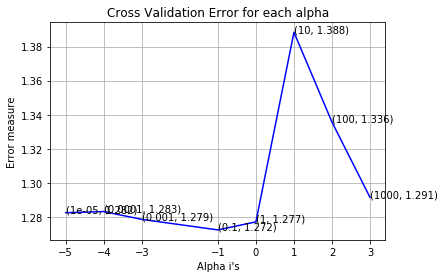

For values of alpha:: 0.1, the train log loss is:: 0.9198715121892317
For values of alpha:: 0.1, the cv log loss is:: 1.2723199843914599
For values of alpha:: 0.1, the test log loss is:: 1.2770027616380548


In [63]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []

cv_log_error = []

for i in alpha:
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    calib_clf = CalibratedClassifierCV(clf, method='sigmoid')
    calib_clf.fit(train_x_onehotCoding, train_y)
    y_proba = calib_clf.predict_proba(cv_x_onehotCoding)
    loss = log_loss(cv_y, y_proba, labels=clf.classes_, eps=1e-15)
    cv_log_error.append(loss)
    print('For values of alpha = ', i, "The log loss is:",loss)

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error, c='b')
for i, txt in enumerate(np.round(cv_log_error, 3)):
    ax.annotate((alpha[i], np.round(txt, 3)), (np.log10(alpha[i]), cv_log_error[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
calib_clf = CalibratedClassifierCV(clf, method='sigmoid')
calib_clf.fit(train_x_onehotCoding, train_y)

predicted_y = calib_clf.predict_proba(train_x_onehotCoding)
print(f"For values of alpha:: {alpha[best_alpha]}, the train log loss is:: {log_loss(train_y, predicted_y, labels=clf.classes_, eps=1e-15)}")
predicted_y = calib_clf.predict_proba(cv_x_onehotCoding)
print(f"For values of alpha:: {alpha[best_alpha]}, the cv log loss is:: {log_loss(cv_y, predicted_y, labels=clf.classes_, eps=1e-15)}")
predicted_y = calib_clf.predict_proba(test_x_onehotCoding)
print(f"For values of alpha:: {alpha[best_alpha]}, the test log loss is:: {log_loss(test_y, predicted_y, labels=clf.classes_, eps=1e-15)}")
   

<h4> Testing the model with best hyper paramters</h4>

Log loss:: 1.2770027616380548
Number of mis-classified points:: 0.3969924812030075
:::::::::::::::::::: Confusion matrix ::::::::::::::::::::


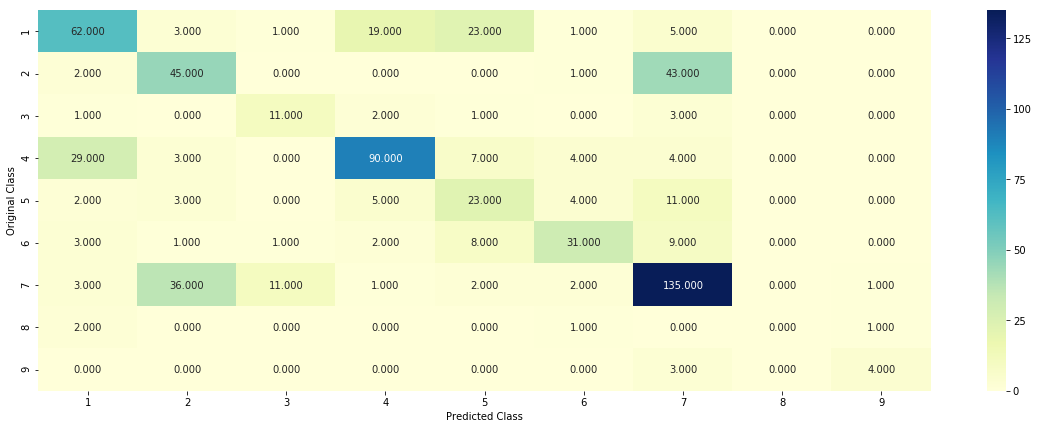

:::::::::::::::::::: Precision matrix ::::::::::::::::::::


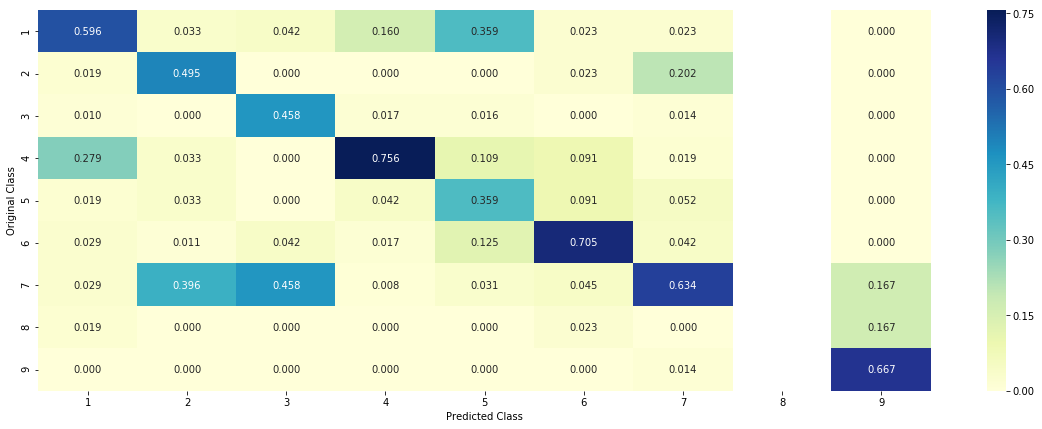

:::::::::::::::::::: Recall matrix ::::::::::::::::::::


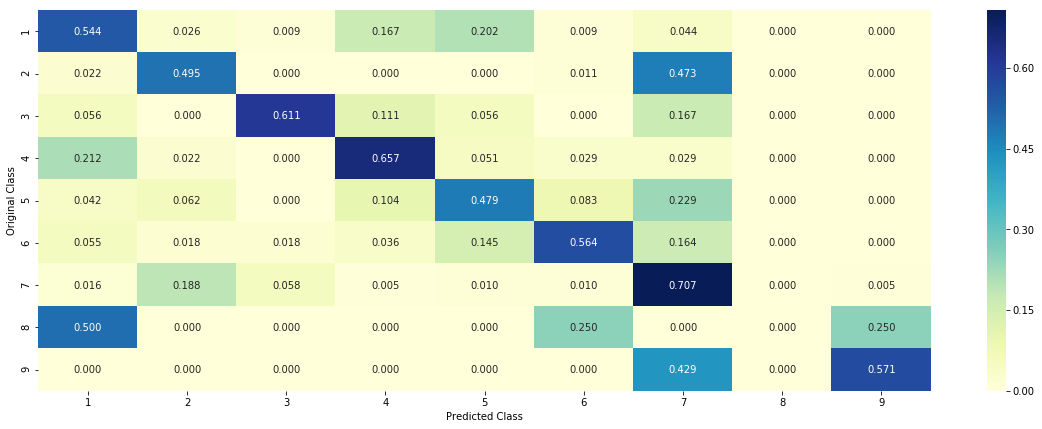

In [69]:
clf = MultinomialNB(alpha=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, test_x_onehotCoding, test_y, clf)


<h4> Feature Importance, Correctly classified point</h4>

In [72]:
test_point_index = 1
num_feature = 100
predicted_cls = calib_clf.predict(test_x_onehotCoding[test_point_index])
print(f"Predicted Class:: {predicted_cls[0]}",)
print("Predicted Class Probabilities:", np.round(calib_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls - 1][:,:num_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], num_feature)



Predicted Class:: 7
Predicted Class Probabilities: [[0.0838 0.0731 0.0142 0.1067 0.0332 0.0319 0.65   0.0041 0.003 ]]
Actual Class : 2
--------------------------------------------------
13 Text feature [kinase] present in test data point [True]
14 Text feature [presence] present in test data point [True]
17 Text feature [inhibitor] present in test data point [True]
18 Text feature [recently] present in test data point [True]
20 Text feature [previously] present in test data point [True]
21 Text feature [suggest] present in test data point [True]
22 Text feature [however] present in test data point [True]
25 Text feature [shown] present in test data point [True]
26 Text feature [contrast] present in test data point [True]
27 Text feature [well] present in test data point [True]
29 Text feature [addition] present in test data point [True]
30 Text feature [showed] present in test data point [True]
31 Text feature [also] present in test data point [True]
33 Text feature [similar] present i

<h4> Feature Importance, Incorrectly classified point</h4>

In [ ]:
# num_feature = 100
# predicted_y = calib_clf.predict(test_x_onehotCoding)
# test_point_index = np.where(predicted_y != test_y)[0][0]
# predicted_cls = predicted_y[test_point_index]
# print(f"Predicted Class:: {predicted_cls}",)
# print("Predicted Class Probabilities:", np.round(calib_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
# print("Actual Class :", test_y[test_point_index])
# indices = np.argsort(-clf.coef_)[predicted_cls][:num_feature]
# print("-"*50)
# get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], num_feature)



In [73]:
test_point_index = 6
num_feature = 100
predicted_cls = calib_clf.predict(test_x_onehotCoding[test_point_index])
print(f"Predicted Class:: {predicted_cls[0]}",)
print("Predicted Class Probabilities:", np.round(calib_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls - 1][:,:num_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], num_feature)



Predicted Class:: 5
Predicted Class Probabilities: [[0.2611 0.0906 0.0175 0.1319 0.2905 0.0395 0.1601 0.0051 0.0037]]
Actual Class : 5
--------------------------------------------------
6 Text feature [functional] present in test data point [True]
7 Text feature [assays] present in test data point [True]
Out of the top  100  features  2 are present in query point


<h2> K Nearest Neighbour Classification </h2>

For values of alpha =  5 The log loss is: 1.2474742453998566
For values of alpha =  11 The log loss is: 1.3055884185724074
For values of alpha =  15 The log loss is: 1.3274823785270313
For values of alpha =  21 The log loss is: 1.3442630389566035
For values of alpha =  31 The log loss is: 1.3816280877017553
For values of alpha =  41 The log loss is: 1.381395363697274
For values of alpha =  51 The log loss is: 1.3752989750805742
For values of alpha =  99 The log loss is: 1.3628657638827986


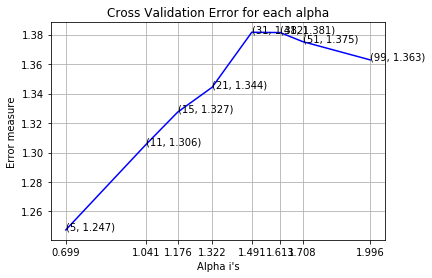

For values of alpha:: 5, the train log loss is:: 1.037958466270214
For values of alpha:: 5, the cv log loss is:: 1.2474742453998566
For values of alpha:: 5, the test log loss is:: 1.2479381247930676


In [74]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error = []

for i in alpha:
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_onehotCoding, train_y)
    calib_clf = CalibratedClassifierCV(clf, method='sigmoid')
    calib_clf.fit(train_x_onehotCoding, train_y)
    y_proba = calib_clf.predict_proba(cv_x_onehotCoding)
    loss = log_loss(cv_y, y_proba, labels=clf.classes_, eps=1e-15)
    cv_log_error.append(loss)
    print('For values of alpha = ', i, "The log loss is:",loss)

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error, c='b')
for i, txt in enumerate(np.round(cv_log_error, 3)):
    ax.annotate((alpha[i], np.round(txt, 3)), (np.log10(alpha[i]), cv_log_error[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
calib_clf = CalibratedClassifierCV(clf, method='sigmoid')
calib_clf.fit(train_x_onehotCoding, train_y)

predicted_y = calib_clf.predict_proba(train_x_onehotCoding)
print(f"For values of alpha:: {alpha[best_alpha]}, the train log loss is:: {log_loss(train_y, predicted_y, labels=clf.classes_, eps=1e-15)}")
predicted_y = calib_clf.predict_proba(cv_x_onehotCoding)
print(f"For values of alpha:: {alpha[best_alpha]}, the cv log loss is:: {log_loss(cv_y, predicted_y, labels=clf.classes_, eps=1e-15)}")
predicted_y = calib_clf.predict_proba(test_x_onehotCoding)
print(f"For values of alpha:: {alpha[best_alpha]}, the test log loss is:: {log_loss(test_y, predicted_y, labels=clf.classes_, eps=1e-15)}")
   

Log loss:: 1.2479381247930676
Number of mis-classified points:: 0.3879699248120301
:::::::::::::::::::: Confusion matrix ::::::::::::::::::::


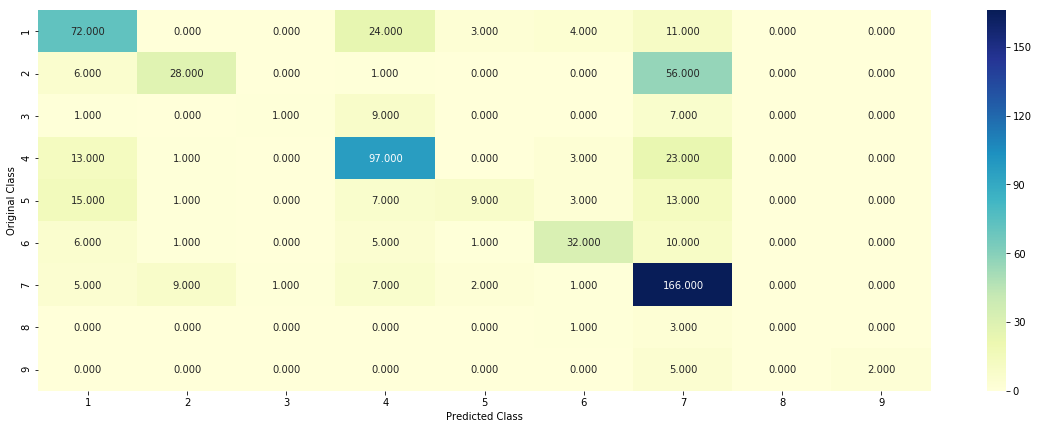

:::::::::::::::::::: Precision matrix ::::::::::::::::::::


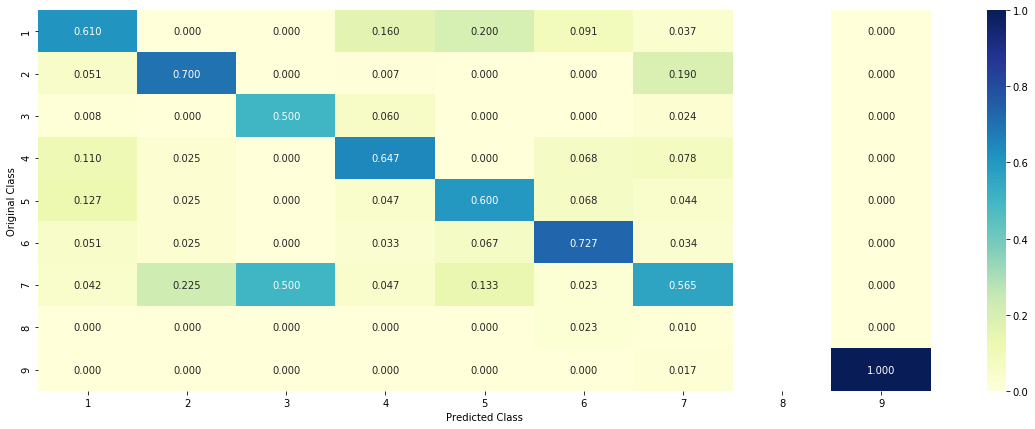

:::::::::::::::::::: Recall matrix ::::::::::::::::::::


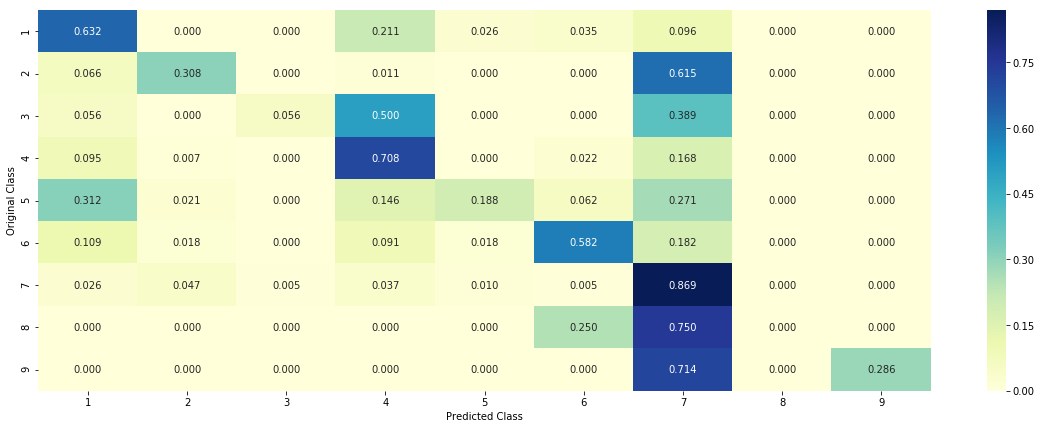

In [75]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, test_x_onehotCoding, test_y, clf)


<h3> Sample Query point - 1 </h3>

In [76]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(train_x_onehotCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(train_x_onehotCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))


Predicted Class : 4
Actual Class : 2
The  5  nearest neighbours of the test points belongs to classes [2 7 7 1 6]
Fequency of nearest points : Counter({7: 2, 2: 1, 1: 1, 6: 1})


In [77]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 100
predicted_cls = sig_clf.predict(train_x_onehotCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(train_x_onehotCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))


Predicted Class : 4
Actual Class : 7
The  5  nearest neighbours of the test points belongs to classes [7 2 7 2 2]
Fequency of nearest points : Counter({2: 3, 7: 2})


<h2> Logistic Regression</h2>

<h3> With Class balancing</h3>

<h4> Hyper paramter tuning</h4>

For values of alpha =  1e-06 The log loss is: 1.3504566655459083
For values of alpha =  1e-05 The log loss is: 1.2925837152078112
For values of alpha =  0.0001 The log loss is: 1.1308242106658115
For values of alpha =  0.001 The log loss is: 1.1044973270630565
For values of alpha =  0.01 The log loss is: 1.185165869823572
For values of alpha =  0.1 The log loss is: 1.4847638700637649
For values of alpha =  1 The log loss is: 1.684742723981946
For values of alpha =  10 The log loss is: 1.7099223609114975
For values of alpha =  100 The log loss is: 1.7125751284567479


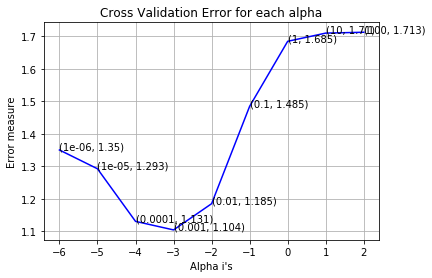

For values of alpha:: 0.001, the train log loss is:: 0.5816141200608325
For values of alpha:: 0.001, the cv log loss is:: 1.1044973270630565
For values of alpha:: 0.001, the test log loss is:: 1.0336558564212452


In [78]:
alpha = [10 ** x for x in range(-6, 3)]

cv_log_error = []

for i in alpha:
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    calib_clf = CalibratedClassifierCV(clf, method='sigmoid')
    calib_clf.fit(train_x_onehotCoding, train_y)
    y_proba = calib_clf.predict_proba(cv_x_onehotCoding)
    loss = log_loss(cv_y, y_proba, labels=clf.classes_, eps=1e-15)
    cv_log_error.append(loss)
    print('For values of alpha = ', i, "The log loss is:",loss)

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error, c='b')
for i, txt in enumerate(np.round(cv_log_error, 3)):
    ax.annotate((alpha[i], np.round(txt, 3)), (np.log10(alpha[i]), cv_log_error[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error)
clf = SGDClassifier(alpha=alpha[best_alpha], class_weight='balanced', penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
calib_clf = CalibratedClassifierCV(clf, method='sigmoid')
calib_clf.fit(train_x_onehotCoding, train_y)

predicted_y = calib_clf.predict_proba(train_x_onehotCoding)
print(f"For values of alpha:: {alpha[best_alpha]}, the train log loss is:: {log_loss(train_y, predicted_y, labels=clf.classes_, eps=1e-15)}")
predicted_y = calib_clf.predict_proba(cv_x_onehotCoding)
print(f"For values of alpha:: {alpha[best_alpha]}, the cv log loss is:: {log_loss(cv_y, predicted_y, labels=clf.classes_, eps=1e-15)}")
predicted_y = calib_clf.predict_proba(test_x_onehotCoding)
print(f"For values of alpha:: {alpha[best_alpha]}, the test log loss is:: {log_loss(test_y, predicted_y, labels=clf.classes_, eps=1e-15)}")
   

Log loss:: 1.1044973270630565
Number of mis-classified points:: 0.32894736842105265
:::::::::::::::::::: Confusion matrix ::::::::::::::::::::


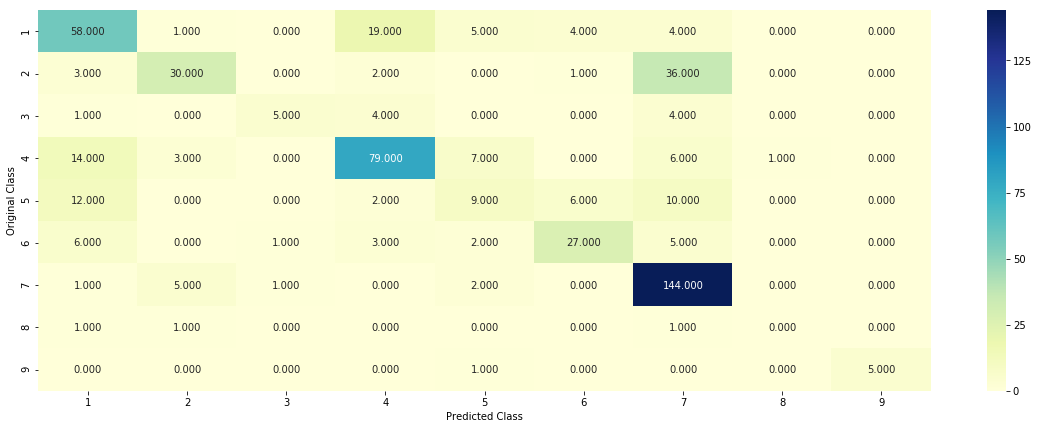

:::::::::::::::::::: Precision matrix ::::::::::::::::::::


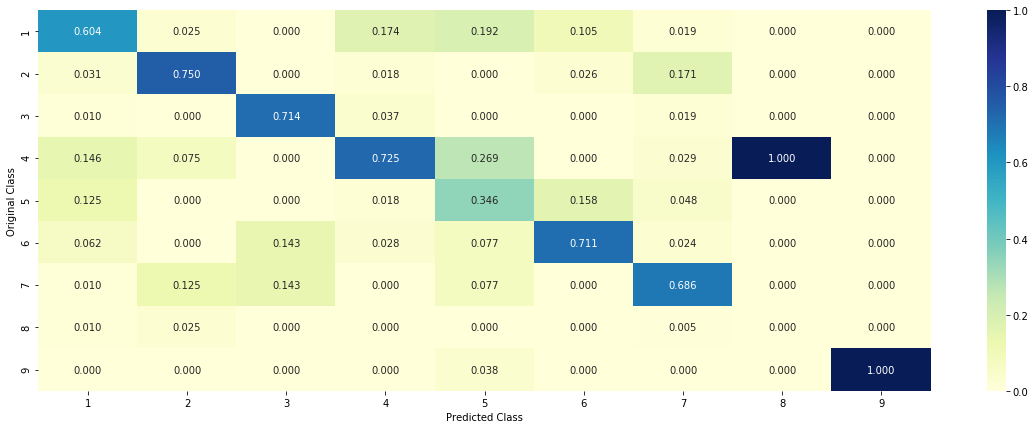

:::::::::::::::::::: Recall matrix ::::::::::::::::::::


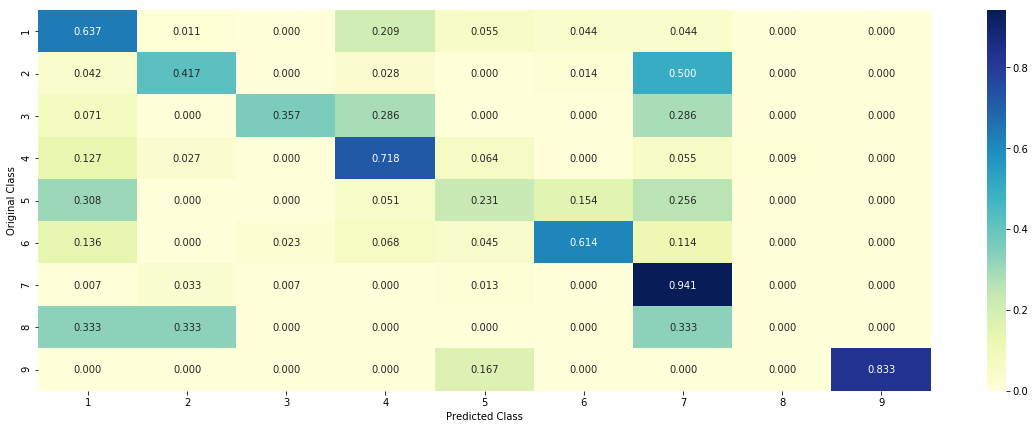

In [79]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [80]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.0806 0.5617 0.0174 0.0529 0.0401 0.0302 0.2044 0.0062 0.0066]]
Actual Class : 2
--------------------------------------------------
373 Text feature [g719c] present in test data point [True]
431 Text feature [taiwanese] present in test data point [True]
Out of the top  500  features  2 are present in query point


<h2> Linear Support Vector Machines</h2>

For values of alpha =  1e-05 The log loss is: 1.330653299994998
For values of alpha =  0.0001 The log loss is: 1.2319305064949548
For values of alpha =  0.001 The log loss is: 1.1256838625883965
For values of alpha =  0.01 The log loss is: 1.1292412310088724
For values of alpha =  0.1 The log loss is: 1.4159337702251729
For values of alpha =  1 The log loss is: 1.7012410401919882
For values of alpha =  10 The log loss is: 1.7129819807554834
For values of alpha =  100 The log loss is: 1.7130099610770415


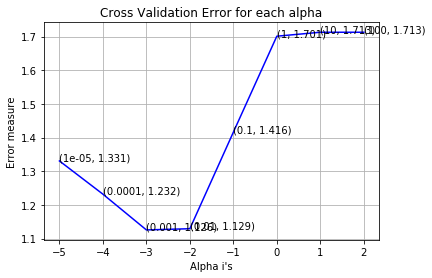

For values of alpha:: 0.001, the train log loss is:: 0.6004869966735534
For values of alpha:: 0.001, the cv log loss is:: 1.1256838625883965
For values of alpha:: 0.001, the test log loss is:: 1.1009494286309065


In [81]:
alpha = [10 ** x for x in range(-5, 3)]

cv_log_error = []

for i in alpha:
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    calib_clf = CalibratedClassifierCV(clf, method='sigmoid')
    calib_clf.fit(train_x_onehotCoding, train_y)
    y_proba = calib_clf.predict_proba(cv_x_onehotCoding)
    loss = log_loss(cv_y, y_proba, labels=clf.classes_, eps=1e-15)
    cv_log_error.append(loss)
    print('For values of alpha = ', i, "The log loss is:",loss)

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error, c='b')
for i, txt in enumerate(np.round(cv_log_error, 3)):
    ax.annotate((alpha[i], np.round(txt, 3)), (np.log10(alpha[i]), cv_log_error[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error)
clf = SGDClassifier(alpha=alpha[best_alpha], class_weight='balanced', penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
calib_clf = CalibratedClassifierCV(clf, method='sigmoid')
calib_clf.fit(train_x_onehotCoding, train_y)

predicted_y = calib_clf.predict_proba(train_x_onehotCoding)
print(f"For values of alpha:: {alpha[best_alpha]}, the train log loss is:: {log_loss(train_y, predicted_y, labels=clf.classes_, eps=1e-15)}")
predicted_y = calib_clf.predict_proba(cv_x_onehotCoding)
print(f"For values of alpha:: {alpha[best_alpha]}, the cv log loss is:: {log_loss(cv_y, predicted_y, labels=clf.classes_, eps=1e-15)}")
predicted_y = calib_clf.predict_proba(test_x_onehotCoding)
print(f"For values of alpha:: {alpha[best_alpha]}, the test log loss is:: {log_loss(test_y, predicted_y, labels=clf.classes_, eps=1e-15)}")
   

Log loss:: 1.1256838625883965
Number of mis-classified points:: 0.33646616541353386
:::::::::::::::::::: Confusion matrix ::::::::::::::::::::


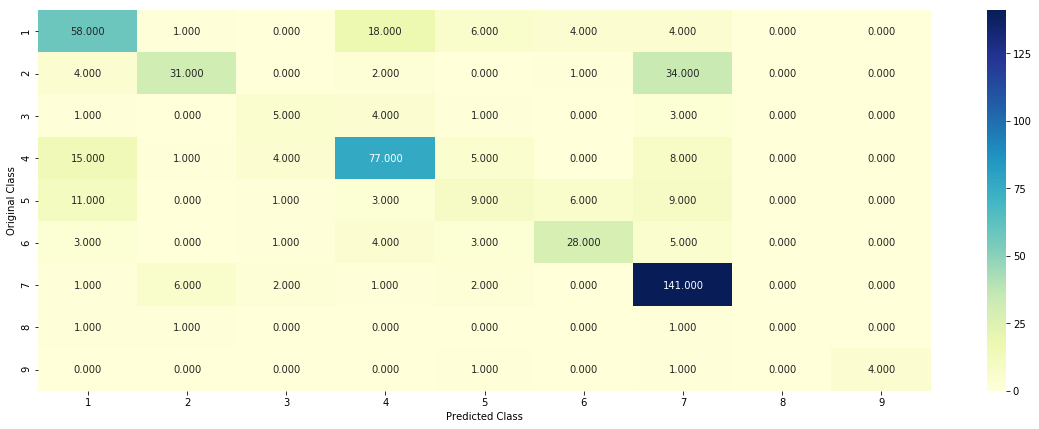

:::::::::::::::::::: Precision matrix ::::::::::::::::::::


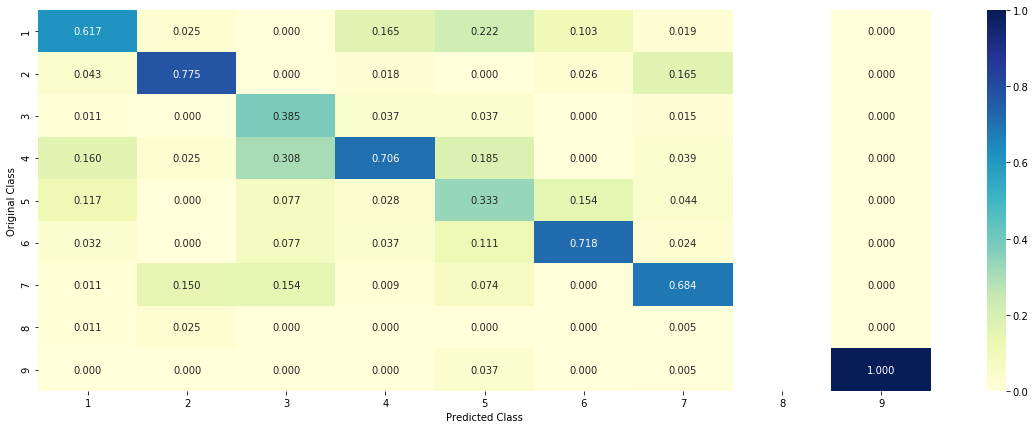

:::::::::::::::::::: Recall matrix ::::::::::::::::::::


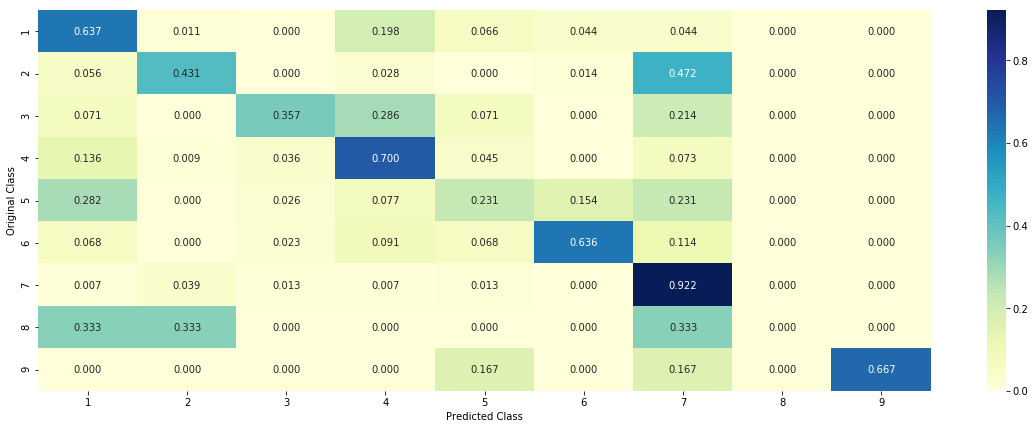

In [82]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [83]:
test_point_index = 1
num_feature = 100
predicted_cls = calib_clf.predict(test_x_onehotCoding[test_point_index])
print(f"Predicted Class:: {predicted_cls[0]}",)
print("Predicted Class Probabilities:", np.round(calib_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls - 1][:,:num_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], num_feature)



Predicted Class:: 7
Predicted Class Probabilities: [[0.1131 0.232  0.0249 0.1276 0.0594 0.0464 0.3824 0.0065 0.0077]]
Actual Class : 2
--------------------------------------------------
Out of the top  100  features  0 are present in query point


<h2> Random Forest Classifier </h2>

For values of estimators:: 100 and depth:: 5, The log loss is:: 1.2382414157737873
For values of estimators:: 100 and depth:: 10, The log loss is:: 1.1468765807753276
For values of estimators:: 100 and depth:: 25, The log loss is:: 1.1747478598444405
For values of estimators:: 100 and depth:: 100, The log loss is:: 1.1930074194964408
For values of estimators:: 200 and depth:: 5, The log loss is:: 1.2165900902100844
For values of estimators:: 200 and depth:: 10, The log loss is:: 1.1317251160038673
For values of estimators:: 200 and depth:: 25, The log loss is:: 1.1643595042036612
For values of estimators:: 200 and depth:: 100, The log loss is:: 1.1829296204109703
For values of estimators:: 500 and depth:: 5, The log loss is:: 1.2075174702319644
For values of estimators:: 500 and depth:: 10, The log loss is:: 1.126537917997267
For values of estimators:: 500 and depth:: 25, The log loss is:: 1.1612878521815946
For values of estimators:: 500 and depth:: 100, The log loss is:: 1.1777508753

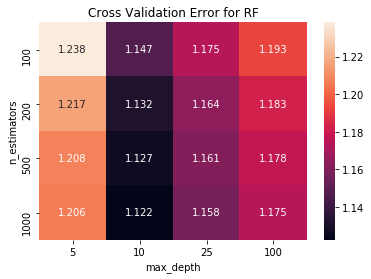

For values of estimators:: 1000, and depth:: 10, the train log loss is:: 0.72465000968218
For values of estimators:: 1000, and depth:: 10, the cv log loss is:: 1.1224099517254125
For values of estimators:: 1000, and depth:: 10, the test log loss is:: 1.1389928865154524


In [112]:
alpha = [100,200,500,1000]
max_depth = [5, 10, 25, 100]


cv_log_error = []

for i in alpha:
    cv_error = []
    for j in max_depth:
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        calib_clf = CalibratedClassifierCV(clf, method='sigmoid')
        calib_clf.fit(train_x_onehotCoding, train_y)
        y_proba = calib_clf.predict_proba(cv_x_onehotCoding)
        loss = log_loss(cv_y, y_proba, labels=clf.classes_, eps=1e-15)
        cv_error.append(loss)
        print(f"For values of estimators:: {i} and depth:: {j}, The log loss is:: {loss}")
    cv_log_error.append(cv_error)
cv_log_error=np.array(cv_log_error)

n = len(max_depth)
m = len(alpha)
df_plot = pd.DataFrame(data=cv_log_error, index=alpha, columns=max_depth)
sns.heatmap(df_plot, annot = True, fmt='.4g')
plt.title("Cross Validation Error for RF")
plt.xlabel("max_depth")
plt.ylabel("n_estimators")
plt.show()

indx = np.unravel_index(np.argmin(cv_log_error, axis=None), cv_log_error.shape)
best_alpha = alpha[indx[0]]
best_depth = max_depth[indx[1]]
clf = RandomForestClassifier(n_estimators=best_alpha, criterion='gini', max_depth=best_depth, random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
calib_clf = CalibratedClassifierCV(clf, method='sigmoid')
calib_clf.fit(train_x_onehotCoding, train_y)

predicted_y = calib_clf.predict_proba(train_x_onehotCoding)
print(f"For values of estimators:: {best_alpha}, and depth:: {best_depth}, the train log loss is:: {log_loss(train_y, predicted_y, labels=clf.classes_, eps=1e-15)}")
predicted_y = calib_clf.predict_proba(cv_x_onehotCoding)
print(f"For values of estimators:: {best_alpha}, and depth:: {best_depth}, the cv log loss is:: {log_loss(cv_y, predicted_y, labels=clf.classes_, eps=1e-15)}")
predicted_y = calib_clf.predict_proba(test_x_onehotCoding)
print(f"For values of estimators:: {best_alpha}, and depth:: {best_depth}, the test log loss is:: {log_loss(test_y, predicted_y, labels=clf.classes_, eps=1e-15)}") 

Log loss:: 1.1224099517254125
Number of mis-classified points:: 0.34022556390977443
:::::::::::::::::::: Confusion matrix ::::::::::::::::::::


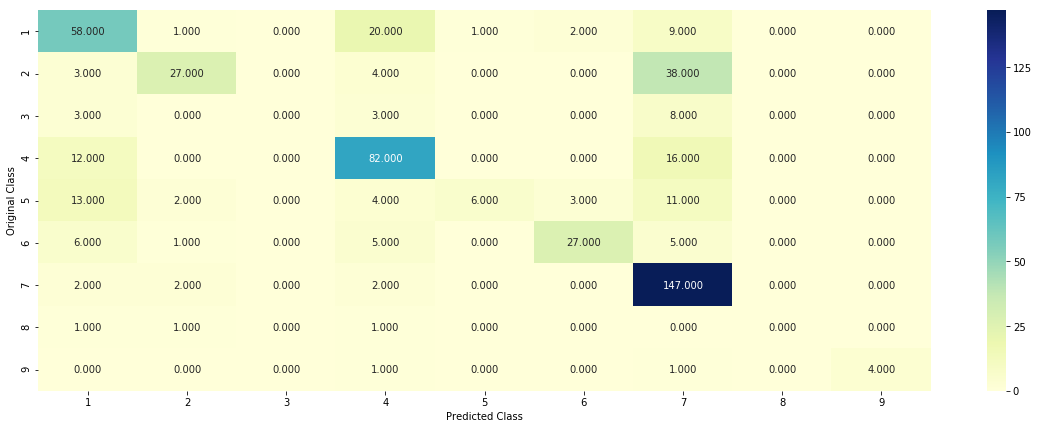

:::::::::::::::::::: Precision matrix ::::::::::::::::::::


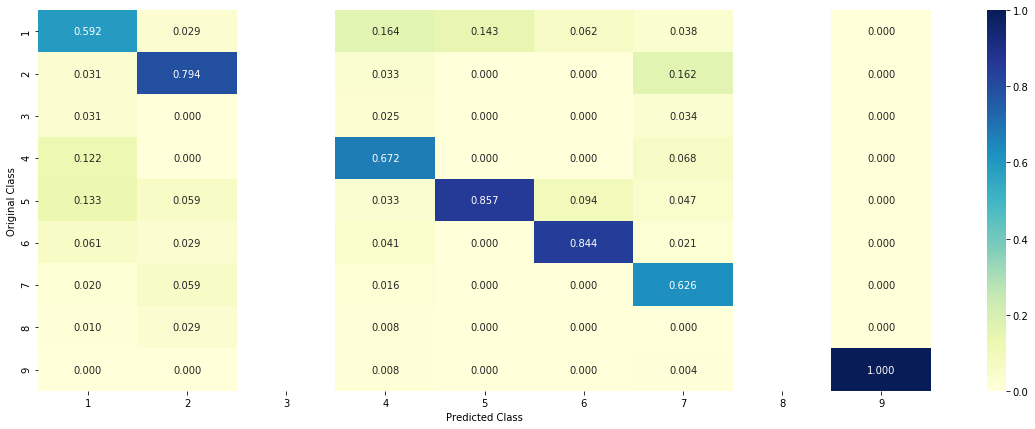

:::::::::::::::::::: Recall matrix ::::::::::::::::::::


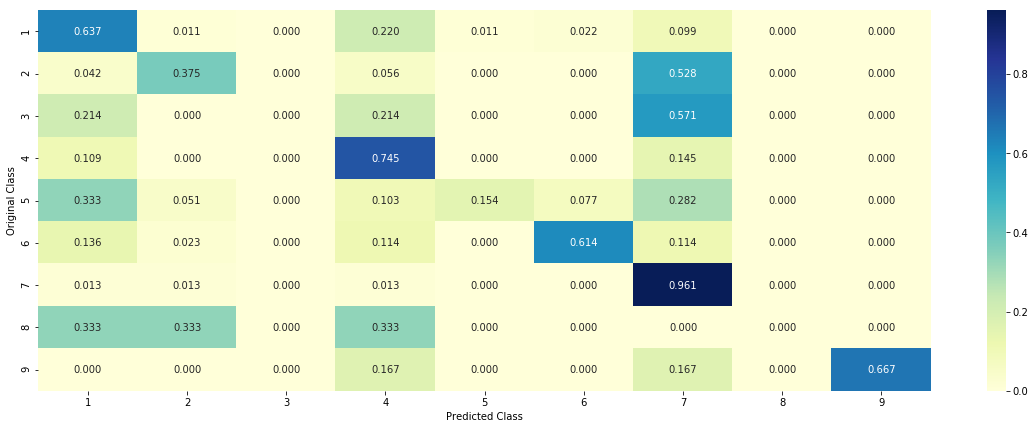

In [106]:
clf = RandomForestClassifier(n_estimators=best_alpha, criterion='gini', max_depth=best_depth, random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

In [108]:
test_point_index = 1
num_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:num_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], num_feature)



Predicted Class : 2
Predicted Class Probabilities: [[0.0806 0.5617 0.0174 0.0529 0.0401 0.0302 0.2044 0.0062 0.0066]]
Actual Class : 2
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
5 Text feature [tyrosine] present in test data point [True]
6 Text feature [inhibitor] present in test data point [True]
8 Text feature [inhibitors] present in test data point [True]
15 Text feature [treatment] present in test data point [True]
16 Text feature [trials] present in test data point [True]
17 Text feature [growth] present in test data point [True]
18 Text feature [months] present in test data point [True]
20 Text feature [efficacy] present in test data point [True]
22 Text feature [receptor] present in test data point [True]
25 Text feature [signaling] present in test data point [True]
27 Text feature [kinases] present in test data point [True]
39 Text feature [patients] present in test data point [True]
47 Text feature [therapy] pre

<h2> Stack the models </h2>

In [109]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.10
Support vector machines : Log Loss: 1.70
Naive Bayes : Log Loss: 1.28
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.178
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.038
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.510
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.110
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.217
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.515


<h3> testing the model with the best hyper parameters</h3>

Log loss (train) on the stacking classifier : 0.6527441478884537
Log loss (CV) on the stacking classifier : 1.1101078781764329
Log loss (test) on the stacking classifier : 1.1011210187018565
Number of missclassified point : 0.3609022556390977
:::::::::::::::::::: Confusion matrix ::::::::::::::::::::


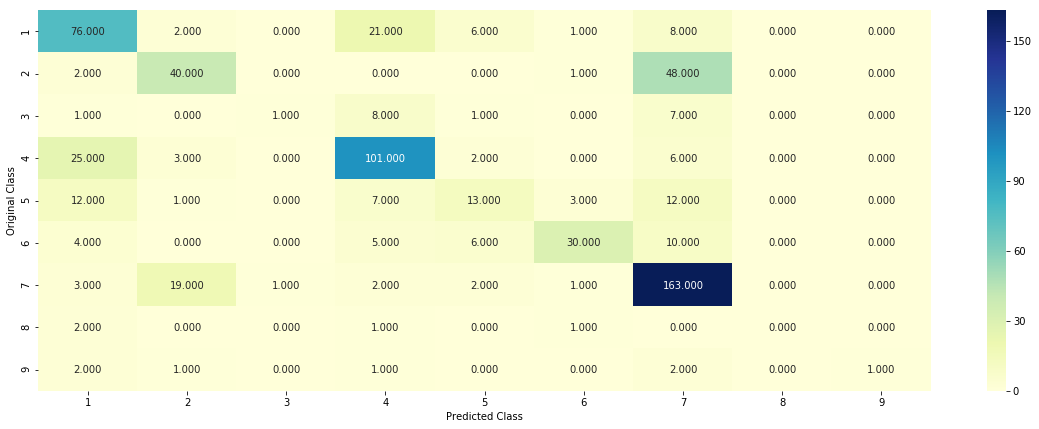

:::::::::::::::::::: Precision matrix ::::::::::::::::::::


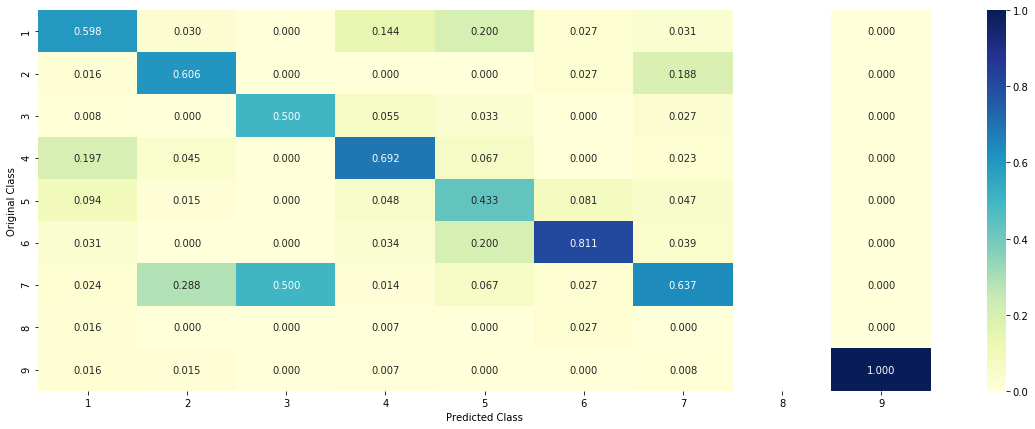

:::::::::::::::::::: Recall matrix ::::::::::::::::::::


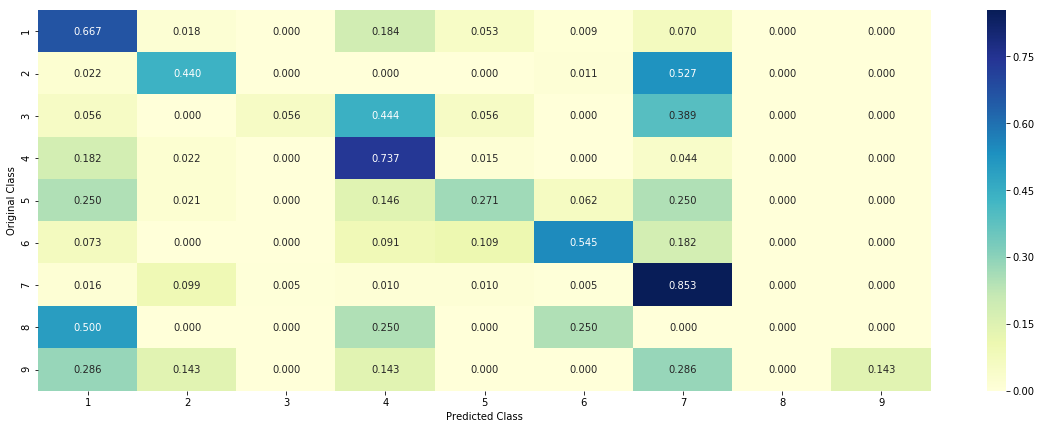

In [110]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

<h3> Maximum Voting classifier </h3>

Log loss (train) on the VotingClassifier : 0.9117480866741318
Log loss (CV) on the VotingClassifier : 1.2039595303375932
Log loss (test) on the VotingClassifier : 1.1974870049178639
Number of missclassified point : 0.36541353383458647
:::::::::::::::::::: Confusion matrix ::::::::::::::::::::


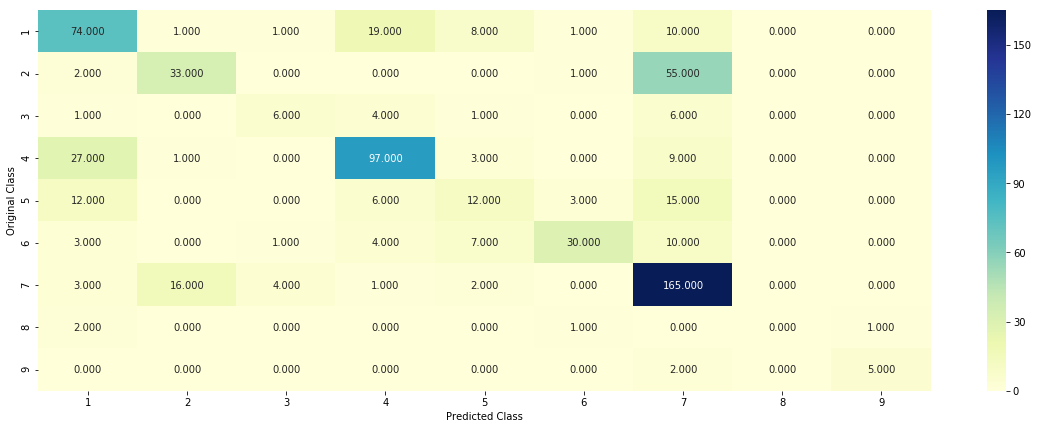

:::::::::::::::::::: Precision matrix ::::::::::::::::::::


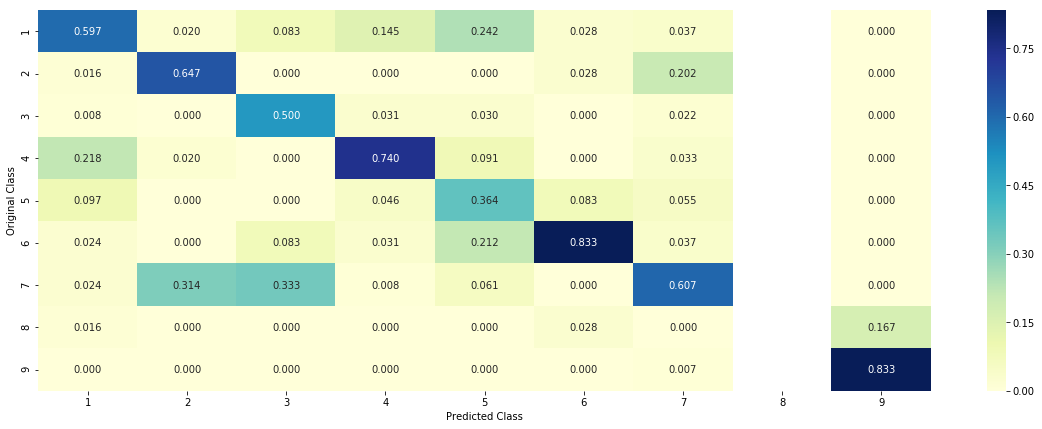

:::::::::::::::::::: Recall matrix ::::::::::::::::::::


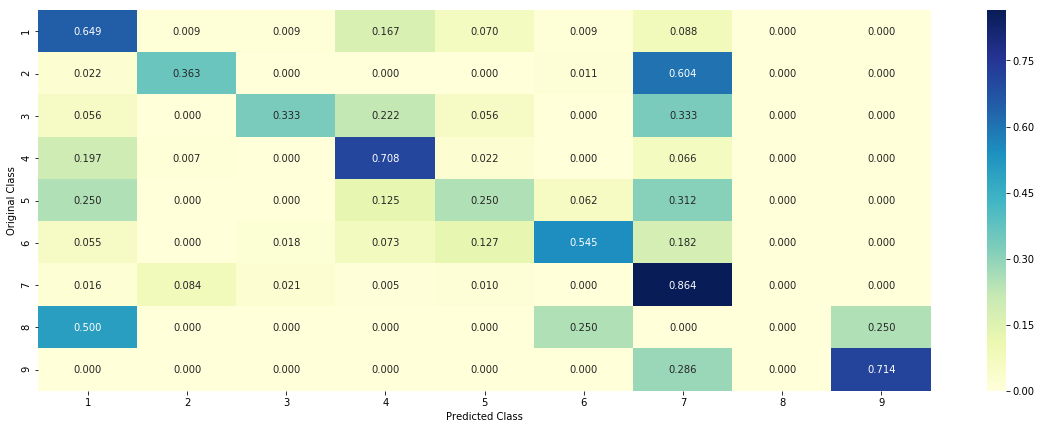

In [111]:
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))